In [1]:
%matplotlib inline

### New USPORF classes (adapted from eif.py)
[eif.py link](https://github.com/sahandha/eif/blob/master/eif_old.py)

In [39]:
"""
EXP 6:
Usporf structure
Goal: EIF split with A matrix
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import time
import random as rn
import os
import warnings
from sklearn.base import BaseEstimator

def c_factor(n) :
    """
    Average path length of unsuccesful search in a binary search tree given n points
    
    Parameters
    ----------
    n : int
        Number of data points for the BST.
    Returns
    -------
    float
        Average path length of unsuccesful search in a BST
        
    """
    return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))

def FastBIC(Z_arr):  ## USPROF Algo 3
    """
    calculate the splitPoint and nim BIC score from 1D array
    """
    N = Z_arr.shape[0]
    Z_ind = np.argsort(Z_arr)
    minBIC = np.inf

    for s in range(2, (N+1)-2):
        Curr_1 = Z_arr[Z_ind[:s]]
        Curr_2 = Z_arr[Z_ind[s:]]
        var_1 = np.var(Curr_1)
        var_2 = np.var(Curr_2)
        if (var_1 == 0) or (var_2 == 0):
            continue  # ignore var = 0
        
        n_1 = s
        n_2 = N-s
        pi_1 = s/N
        pi_2 = (N-s)/N
        var_comb = (pi_1*var_1 + pi_2*var_2)
        BIC_diff_var = -2*(n_1*np.log(pi_1)
                           - n_1/2*np.log(2*np.pi*var_1)
                           + n_2*np.log(pi_2)
                           - n_2/2*np.log(2*np.pi*var_2))
        BIC_same_var = -2*(n_1*np.log(pi_1)
                           - n_1/2*np.log(2*np.pi*var_comb)
                           + n_2*np.log(pi_2)
                           - n_2/2*np.log(2*np.pi*var_comb))
        BIC_curr = min(BIC_diff_var, BIC_same_var)

        if BIC_curr < minBIC:
            minBIC = BIC_curr
            splitPoint = (Z_arr[Z_ind[s-1]] + Z_arr[Z_ind[s]])/2
            
    return(splitPoint, minBIC)

def projectA(dim, d, Lambda =1/20):
    """
    Lambda = 1/20, 
    """
    A = np.random.choice([-1, 0, 1], dim*d, 
                         p=[Lambda/2, 1-Lambda, Lambda/2]
                        ).reshape(dim,d)
    if np.count_nonzero(A)==0:  # repeat if get the zero-matrix
        return projectA(dim, d, Lambda = 1/(dim*d))
    else:
        return A

class UForest(object):  ## USPORF algo 1
    """
    Creates an iForest object. This object holds the data as well as the trained trees (iTree objects).
    Attributes
    ----------
    n_samples: int
        Size of the dataset.
    sample: int
        Size of the sample to be used for tree creation.
    Trees: list
        A list of tree objects.
    max_depth: int
        Maximum depth a tree can have.
    exlevel: int
        Exention level to be used in the creating splitting critera.
    c: float
        Multiplicative factor used in computing the anomaly scores.
    Methods
    -------
    CheckExtensionLevel()
        Chaeck the validity of extension level provided by user based on the data
    compute_paths(X_in)
        Computes the anomaly score for data X_in
    """
    def __init__(self, n_estimators,  max_samples=None , max_depth=None, d=None, ExtensionLevel=0, Lambda = 1/20):
        """
        iForest(n_estimators,  max_samples, max_depth=None, ExtensionLevel=0)
        Initialize a forest by passing in training data, number of trees to be used and the subsample size.
        Parameters
        ----------
        n_estimators : int
            Number of trees to be used.
        max_samples : int
            The size of the subsample to be used in creation of each tree. Must be smaller than |X|
        max_depth : int
            The maximum allowed tree depth. This is by default set to average length of unsucessful search in a binary tree.
        ExtensionLevel : int
            Specifies degree of freedom in choosing the hyperplanes for dividing up data. Must be smaller than the dimension n of the dataset.
        Lambda = 1/20 : float
            Ratio of non zero element in sparse A matrix
        d = None: int
            number of projected featur. default = np.int(np.sqrt(X.shape[1]))
        """
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.exlevel = ExtensionLevel
   
        self.Lambda = Lambda  # 1/20: prob of +1, -1 element in sparse projected matrix `A`
        self.d = d  # number of sparse projected features

    def fit(self, X, y=None):
        self.Trees = []
        self.X_ = X
        n_samples = X.shape[0]
        dim = X.shape[1]
        
        if self.max_samples is None:
            self.max_samples = min(256, n_samples)
        if self.max_depth is None:
            self.max_depth = int(np.ceil(np.log2(self.max_samples)))  # Set max_depth to the default as specified by the paper (average depth of unsuccesful search through a binary tree).
        
        self.d = d
        if d is None:
            self.d = int(np.log(dim))  # d: number of projected feature
            
        self.c = c_factor(self.max_samples)
        for i in range(self.n_estimators):  # This loop builds an ensemble of iTrees (the forest).
            ix = rn.sample(range(n_samples), self.max_samples)  # subset  
            X_p = X[ix]
            self.Trees.append(iTree(X_p, 0, self.max_depth, d=self.d  ,exlevel=self.exlevel, Lambda=self.Lambda))
        self.CheckExtensionLevel()  # Extension Level check. See def for explanation.
        return self

    def CheckExtensionLevel(self):
        """
        This function makes sure the extension level provided by the user does not exceed the dimension of the data. An exception will be raised in the case of a violation.
        """
        dim = self.X_.shape[1]
        if self.exlevel < 0:
            raise Exception("Extension level has to be an integer between 0 and "+ str(dim-1)+".")
        if self.exlevel > dim-1:
            raise Exception("Your data has "+ str(dim) + " dimensions. Extension level can't be higher than " + str(dim-1) + ".")

    def compute_paths(self, X_in = None): # need adjust
        """
        compute_paths(X_in = None)
        Compute anomaly scores for all data points in a dataset X_in
        Parameters
        ----------
        X_in : list of list of floats
                Data to be scored. iForest.Trees are used for computing the depth reached in each tree by each data point.
        Returns
        -------
        float
            Anomaly score for a given data point.
        """
        if X_in is None:
            X_in = self.X_
        S = np.zeros(len(X_in))
        for i in  range(len(X_in)):
            h_temp = 0
            for j in range(self.n_estimators):
                h_temp += PathFactor(X_in[i],self.Trees[j]).path*1.0  # Compute path length for each point
            Eh = h_temp/self.n_estimators  # Average of path length travelled by the point in all trees.
            S[i] = 2.0**(-Eh/self.c)  # Anomaly Score
        return S

class Node(object):
    """
    A single node from each tree (each iTree object). Nodes containe information on hyperplanes used for data division, date to be passed to left and right nodes, whether they are external or internal nodes.
    Attributes
    ----------
    e: int
        Depth of the tree to which the node belongs.
    size: int
        Size of the dataset present at the node.
    d: int
        Dimension of the projected space
    X: list
        Data at the node.
    Aj: list
        project matrix column j
    splitPoint: float
        splitPoint/ split threshold
    lef: Node object
        Left child node.
    right: Node object
        Right child node.
    ntype: str
        The type of the node: 'LeafNode', 'inNode'.
    """
    def __init__(self, X, d, Aj, splitPoint, e, left, right, node_type = '' ):
        # n -> Aj
        # p -> splitPoint / threshold
        # Node(X, dself.Aj, self.splitPoint, e, left, right, node_type = 'LeafNode')
        """
        Node(X, a_j, p, e, left, right, node_type = '' )
        Create a node in a given tree (iTree objectg)
        Parameters
        ----------
        X : list of list of floats
            Training data available to each node. List of [x1,x2,...,xn] coordinate points.
        Aj: list
            project matrix column j
        splitPoint: float
            splitPoint/ split threshold
        left : Node object
            Left child node.
        right : Node object
            Right child node.
        node_type : str
            Specifies if the node is external or internal. Takes two values: 'LeafNode', 'inNode'.
        """
        self.e = e
        self.size = len(X)
        self.X = X # to be removed
        self.d = d
        self.Aj = Aj
        self.splitPoint = splitPoint
        self.left = left
        self.right = right
        self.ntype = node_type

class iTree(object):

    """
    A single tree in the forest that is build using a unique subsample.
    Attributes
    ----------
    exlevel: int
        Extension level used in the splitting criteria.
    e: int
        Depth of tree
    X: list
        Data present at the root node of this tree.
    size: int
        Size of the dataset.
    dim: int
        Dimension of the dataset.
    Q: list
        List of ordered integers smaller than dim.
    l: int
        Maxium depth a tree can reach before its creation is terminated.
    Aj: list
        project matrix column j
    splitPoint: float
        splitPoint/ split threshold
    LeafNodes: int
        The number of external nodes this tree has.
    root: Node object
        At each node create a new tree.
    Methods
    -------
    make_tree(X, e, l)
        Builds the tree recursively from a given node. Returns a Node object.
    """
    def __init__(self, X, e, max_depth, d=None, exlevel=0, Lambda=1/20):
        """
        iTree(X, e, max_depth, d=None, exlevel=0, Lambda=1/20)
        Create a tree
        Parameters
        ----------
        X : list of list of floats
            Subsample of training data. |X| = iForest.max_samples. List of [x1,x2,...,xn] coordinate points
        e : int
            Depth of the tree as it is being traversed down. e <= l.
        d : int
            project features combination
        max_depth : int
            The maximum depth the tree can reach before its creation is terminated.
        exlevel : int
            Specifies degree of freedom in choosing the hyperplanes for dividing up data. Must be smaller than the dimension n of the dataset.
        """
#         self.X = X  #?
#         self.e = e  #?
        self.max_depth = max_depth # use all the way
        self.exlevel = exlevel
        self.Lambda = Lambda # 1/20: prob of +1, -1 element in sparse projected matrix `A`
        
        self.size = X.shape[0]  # n: num of sample in the tree root
        self.min_samples_split = int(np.sqrt(self.size))  # default
        
        self.dim = X.shape[1]  # p: number of original feature
        
        if d is None:
#             self.d = int(np.sqrt(self.dim))  # d: number of projected feature
            self.d = np.floor(np.sqrt(X.shape[1]))
        else:
            self.d = d
        self.d_list = np.arange(d, dtype='int')  # [0,1,2,...,'d'-1] #?

        self.Aj = None
        self.splitPoint = None
        self.LeafNodes = 0  # number of LeafNode / leaf node
        self.root = self.make_tree(X,e)  # Create a tree with root node.

    def make_tree(self,X,e):
        """
        make_tree(X,e,l)
        Builds the tree recursively from a given node. Returns a Node object.
        Parameters
        ----------
        X: list of list of floats
            Subsample of training data. |X| = iForest.max_samples. List of [x1,x2,...,xn] coordinate point.
            Might not equal to the fist `X` in class iTree():
        e : int
            Depth of the tree as it is being traversed down. Integer. e <= max_depth.
        max_depth : int
            The maximum depth the tree can reach before its creation is terminated. Integer.
        Returns
        -------
        Node object
        """
        if e >= self.max_depth or len(X) <= self.min_samples_split:  # LeafNode condition
            left = None
            right = None
            self.LeafNodes += 1
            return Node(X, self.d, self.Aj, self.splitPoint, e, left, right, node_type = 'LeafNode')

        else:   # Build a tree recursively
            A = projectA(self.dim, self.d, self.Lambda)  # [p*d] sparse matrix, A^T in algo 1
            XA = np.dot(X, A) # [n*d] array
            min_t = np.inf
            for j in self.d_list:  # dimension
                (midpt, t_) = FastBIC(XA[:,j])
                if t_ < min_t:
                    bestDim = j
                    splitPoint = midpt
            
            w = XA[:, bestDim] < splitPoint  # spliting criteria            
            return Node(X, self.d, A[:, bestDim], splitPoint, e, left=self.make_tree(X[w], e+1),
                        right=self.make_tree(X[~w], e+1), node_type = 'inNode' )

class PathFactor(object):
    """
    Given a single tree (iTree objext) and a data point x = [x1,x2,...,xn], compute the legth of the path traversed by the point on the tree when it reaches an external node.
    Attributes
    ----------
    path_list: list
        A list of strings 'L' or 'R' which traces the path a data point travels down a tree.
    x: list
        A single data point, which is represented as a list of floats.
    e: int
        The depth of a given node in the tree.
    Methods
    -------
    find_path(T)
        Given a tree, it finds the path a single data points takes.
    """
    def __init__(self,x,itree):
        """
        PathFactor(x, itree)
        Given a single tree (iTree objext) and a data point x = [x1,x2,...,xn], compute the legth of the path traversed by the point on the tree when it reaches an external node.
        Parameters
        ----------
        x : list of floats
            A data point x = [x1, x2, ..., xn].
        itree : iTree object
            A single tree.
        """
        self.path_list=[]
        self.x = x
        self.e = 0
        self.path  = self.find_path(itree.root)

    def find_path(self,T):
        """
        find_path(T)
        Given a tree, find the path for a single data point based on the splitting criteria stored at each node.
        Parameters
        ----------
        T : iTree object (iTree.root object)
        Returns
        -------
        int
            The depth reached by the data point.
        """
        if T.ntype == 'LeafNode':
            if T.size <= 1: return self.e
            else:
                self.e = self.e + c_factor(T.size)
                return self.e
        else:
            Aj = T.Aj
            splitPoint = T.splitPoint
            
            self.e +=1
            
            if np.dot(self.x, Aj) < splitPoint:
                self.path_list.append('L')
                return self.find_path(T.left)
            else:
                self.path_list.append('R')
                return self.find_path(T.right)
        
def all_branches(node, current=[], branches = None):
    """
    Utility function used in generating a graph visualization. It returns all the branches of a given tree so they can be visualized.
    Parameters
    ----------
    node: Node object
    Returns
    -------
    list
        list of branches that were reached.
    """
    current = current[:node.e]
    if branches is None: branches = []
    if node.ntype == 'inNode':
        current.append('L')
        all_branches(node.left, current=current, branches=branches)
        current = current[:-1]
        current.append('R')
        all_branches(node.right, current=current, branches=branches)
    else:
        branches.append(current)
    return branches

### Example

In [40]:
"""
update: adjust EIF to have the same function as IsoForest

isoForest2: change the import to be global
eif2: add fit(self,X) -> problem: the heatmap of 1st data
eif3: add fit, decision_function, predict, change the variable name,
    : correct follow `flake8`
    -> problem the heat map of 1st data, +runtime
eif4: add fit(), change other classes to function
"""

import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from rerf.urerf import UnsupervisedRandomForest
# from sklearn.ensemble import IsolationForest
from urerfwk6 import UnsupervisedRandomForest_new  # adjusted class
import eif as iso

from iforest2 import IsolationForest2
import eif2 as iso2  # add fit function
# add import new usporf here

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn import tree
from sklearn import datasets
import matplotlib.cm as cm
from sklearn.ensemble import RandomTreesEmbedding
from scipy import interpolate

# print(__doc__)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

# -------------------------------------------------
# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
#     make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
#                **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_inliers, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
#     14. * (np.random.RandomState(42).rand(n_inliers, 2) - 0.5)
]

# label the ground truth
y_true = np.concatenate([np.ones(n_inliers), -np.ones(n_outliers)], axis=0)

# -------------------------------------------------
# algorithm
anomaly_algorithms = [
#     ("IF", IsolationForest(contamination=outliers_fraction,
#                            n_estimators=100, random_state=0)),
#     ("IF_new", IsolationForest2(contamination=outliers_fraction,
#                            n_estimators=100, random_state=0)),
#     ("EIF0",0),
    ("EIF2", iso2.iForest(ntrees=100, sample_size=256, ExtensionLevel=0)),
#     ("EIF_new", iso3.iForest(contamination=outliers_fraction,
#                                n_estimators=100, random_state=0)),
    ("USPORF", UnsupervisedRandomForest_new(n_estimators=100, random_state=0)),
    ("USPORF_new", UForest(n_estimators=100, ExtensionLevel=0)),
]

In [41]:
#-------------------------------------------------------------------
# related functions
def mat_to_score(mat, power =2):
    s = (mat**power).sum(axis=1)/mat.shape[0]
    return s

def decision_function(s_train, s_test, less_inlier = True): # array
    if s_test is None:
        s_test=s_train
    if less_inlier == True: 
        s_train = s_train
        s_test = s_test
    if less_inlier == False: 
        s_train = -s_train
        s_test = -s_test
    offset_ = np.percentile(s_train, outliers_fraction*100)
    decision_function = s_test - offset_
    return decision_function
    
def OutPredict(decision_function):
    is_inlier = np.ones(decision_function.shape[0], dtype=int)
    is_inlier[decision_function <= 0] = -1
    return is_inlier

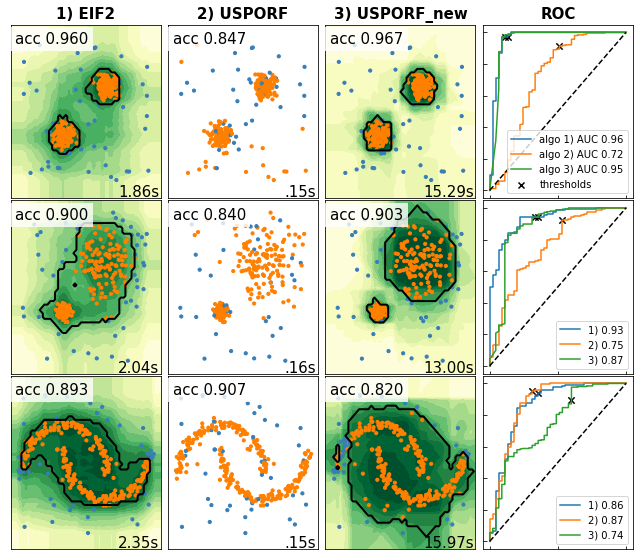

In [42]:
# -------------------------------------------------
# plot

# plot setting
grid_len = np.linspace(-7, 7, 50)
xx, yy = np.meshgrid(grid_len,grid_len)

plt.figure(figsize=((len(anomaly_algorithms)+1) * 2+1, len(datasets)*2.2+1))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
rng = np.random.RandomState(0)

# add outliers
for i_dataset, X in enumerate(datasets):
    X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)
    
    # list of AUC and ROC
    list_AUC = []
    list_fpr = []
    list_tpr = []
    list_thresh = []
    
    algo_index = 0
    for name, algorithm in anomaly_algorithms:
        # fit
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        
        # predict outlier
        if name == "IF": # or name == "IF_new" or name =="EIF_new":
            probas_ = algorithm.fit(X).decision_function(X)
            y_pred = algorithm.predict(X)
        elif name == "EIF2" or name == "USPORF_new":
            s = algorithm.compute_paths(X)
            probas_ = decision_function(s_train=s, s_test=s, less_inlier= False)
            y_pred = OutPredict(decision_function=probas_)
        else:
            d_sim = algorithm.transform()
            s = mat_to_score(mat=d_sim)
            probas_ = decision_function(s_train=s, s_test=s, less_inlier= True)
            y_pred = OutPredict(decision_function=probas_)
        
        AUC = roc_auc_score(y_true, probas_)
        fpr, tpr, thresholds = roc_curve(y_true, probas_)
        thresh_index = np.where(abs(thresholds) == min(abs(thresholds)))[0][0]
        # store ROC curve
        list_AUC.append(AUC)
        list_fpr.append(fpr)
        list_tpr.append(tpr)
        list_thresh.append(thresh_index)

        acc = accuracy_score(y_true, y_pred) # acuracy
        t1 = time.time()
        
        plt.subplot(len(datasets), len(anomaly_algorithms)+1, plot_num)
        if i_dataset == 0:
            plt.title(str(algo_index + 1) + ") " + name, size=15, weight="bold")
        
#------------------------------------------------------ 
# plot contour and decision boundary

        if name == "IF":
            probas_map = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
                
            probas_map= probas_map.reshape(xx.shape)
            Z = Z.reshape(xx.shape)
            lvls = np.linspace(np.min(probas_map),np.max(probas_map),15)
            plt.contourf(xx, yy, probas_map, lvls, cmap=plt.cm.YlGn)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')                

        elif name == "EIF2" or name == "USPORF_new":
            s_test = algorithm.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
            probas_map = decision_function(s_train=s, s_test=s_test,less_inlier= False)
            Z = OutPredict(probas_map)
            
            probas_map= probas_map.reshape(xx.shape)
            Z = Z.reshape(xx.shape)
            lvls = np.linspace(np.min(probas_map),np.max(probas_map),15)
            plt.contourf(xx, yy, probas_map, lvls, cmap=plt.cm.YlGn)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black') 

#-----------------------------------------------------------
# plot outlier prediction
        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        
        # show prediction accuracy
        bbox_props = dict(boxstyle="square", fc="white", ec="none", alpha =0.8)
        plt.text(.03, .89, ("acc %.3f" % acc).lstrip("0"),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment="left", bbox = bbox_props)        
        plot_num += 1
        algo_index += 1
        
#------------------------------------------------------    
# plot the ROC curves and show AUC scores

    plt.subplot(len(datasets), len(anomaly_algorithms) + 1, plot_num) # +1 for ROC column

    if i_dataset == 0:
        plt.title("ROC", size=15, color="black", weight="bold")
        
        # lebel the decision_function's thresholds
        plt.scatter([], [], marker="x", color="black", label="thresholds")
        
    for algo_index in range(len(anomaly_algorithms)):
        
        if i_dataset == 0:
            plt.plot(list_fpr[algo_index], list_tpr[algo_index],
                label="algo " + str(algo_index + 1)+ ")"
                + (" AUC %.2f" % list_AUC[algo_index]).lstrip("0"))
        else:
            plt.plot(list_fpr[algo_index], list_tpr[algo_index],
                label= str(algo_index + 1)+ ")"
                + (" %.2f" % list_AUC[algo_index]).lstrip("0"))
        
        plt.scatter(
        list_fpr[algo_index][list_thresh[algo_index]],
        list_tpr[algo_index][list_thresh[algo_index]],
        s=40, marker="x", color = 'black')
            
    plt.plot(np.array([0, 1]), np.array([0, 1]), linestyle="--", color="black")
    plt.legend()
    plt.tick_params(labelleft = False, labelbottom = False, direction  = "in")
    plot_num += 1     
            
plt.show()

In [ ]:
np.dot(np.ones((10,4)),projectA(4,9,1/(2*3))).shape

In [15]:
d = np.int(np.sqrt(2)); d

1

In [21]:
int(np.sqrt(2)) 

1